# Modern Hopfield Networks

This notebook builds on top of [hopfield-basic](./hopfield-basic.ipynb) to implement the modern Hopfield networks concept

References:
* https://ml-jku.github.io/hopfield-layers/
* https://www.kaggle.com/kostastokis/simpsons-faces

## The problem
What happens when we try to multiple patterns? the $W$ matrix is built from the sum of outer products of the $N$ patterns, or input images:
$$
W = \sum_{i=1}^3x_ix_i^T,\\ x_i \in \{-1, 1\}^d
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from skimage.transform import resize

width, height = 128, 128

def normalize(x):
    x = 2 * ( (x - np.min(x)) / (np.max(x) - np.min(x))) - 1
    return np.sign(x)

def load_images(im_ids):
    imgs = [image.imread(f'subset_bw/{id}') for id in im_ids]
    imgs = [normalize(resize(img, (width, height))) for img in imgs]
    fig, ax = plt.subplots(1, len(imgs), figsize=(16, 6))
    axes = ax.ravel()
    fig.suptitle("Stored patterns ")
    for idx in range(len(imgs)):
        axes[idx].imshow(imgs[idx], cmap='binary_r')
    plt.show()
    return imgs

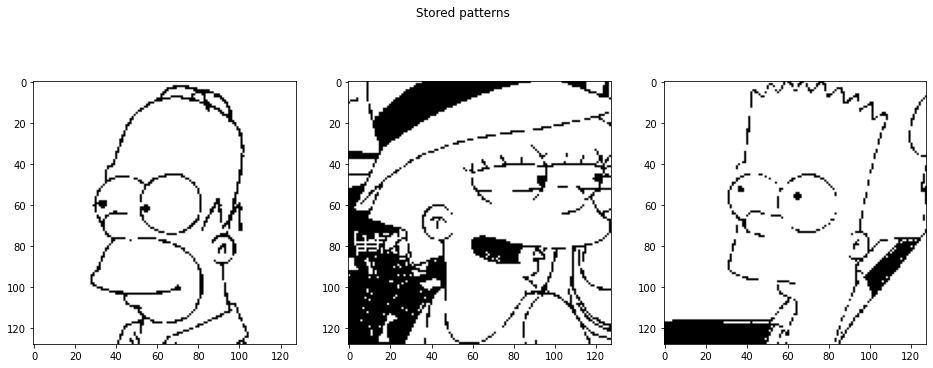

In [2]:
im_ids = ['13.png', '8.png', '28.png']
set1 = load_images(im_ids)

With these three patterns we can build the $W$ matrix as a simple dot product.

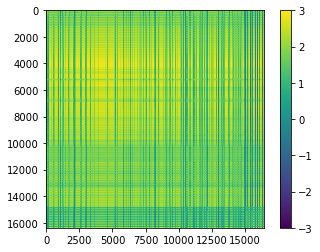

(16384, 16384)


In [3]:
X = np.array([np.array(img).flatten() for img in set1]).T
# W = (1 / (width * height)) * (X @ X.T)
W = X @ X.T
plt.imshow(W)
plt.colorbar()
plt.show()
print(W.shape)


In [4]:
def energy(state, W):
    return -0.5 * state.T @ W @ state

def retrieve_pattern(et, W, sync_update: bool = False, steps: int = 200, energy_fn = energy):
    
    energy_old = np.infty
    energy_new = energy_fn(et, W)
    iteration = 0

    while (energy_old > energy_new) and iteration < steps:
        iteration += 1
        energy_old = energy_new

        # synchronous update, i.e., full
        if sync_update:
            et = np.sign(W @ et)
        else:
        # asynchronous update
            for pixel in np.split(np.random.randint(0,len(et), width * height), 8):
                et[pixel] = np.sign(W[pixel,:] @ et)
        
        energy_new = energy_fn(et, W)

    print(f"Stopped at iteration {iteration}")
    return et

In [5]:
def plot_retrieval(e0, et):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax = axes.ravel()
    ax[0].imshow(e0.reshape(width, height), cmap='binary_r')
    ax[0].set_title('Initial state pattern')
    ax[1].imshow(et.reshape(width, height), cmap='binary_r')
    ax[1].set_title('Retrieved pattern')
    plt.show()

Single point test. Even the single point test fails when dealing with multiple patterns.

Stopped at iteration 8


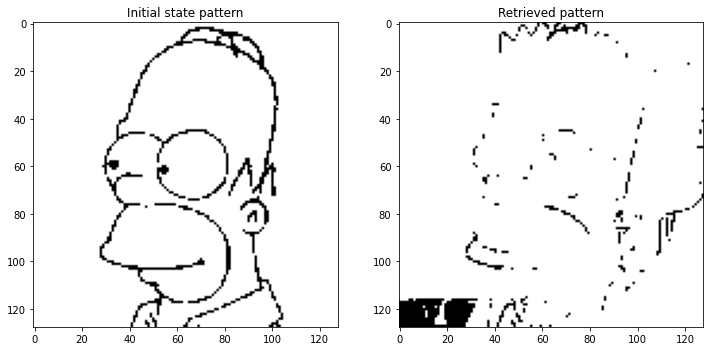

In [6]:
homer = np.sign(np.array(set1[0]).flatten())
retrieved = retrieve_pattern(homer.copy(), W)
plot_retrieval(homer, retrieved)

We can observe that we start having problems here. Now let's see what we got, compared to what we had in the first state pattern

Stopped at iteration 10


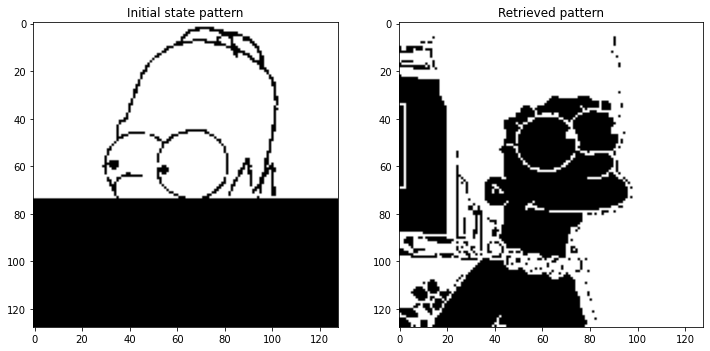

In [9]:
e0 = homer.copy().reshape(width, height)
e0[width // 2 + 10: width, 0:height] = -1.
e0 = e0.flatten().reshape(-1, 1)
et = retrieve_pattern(e0.copy(), W)
plot_retrieval(e0, et)

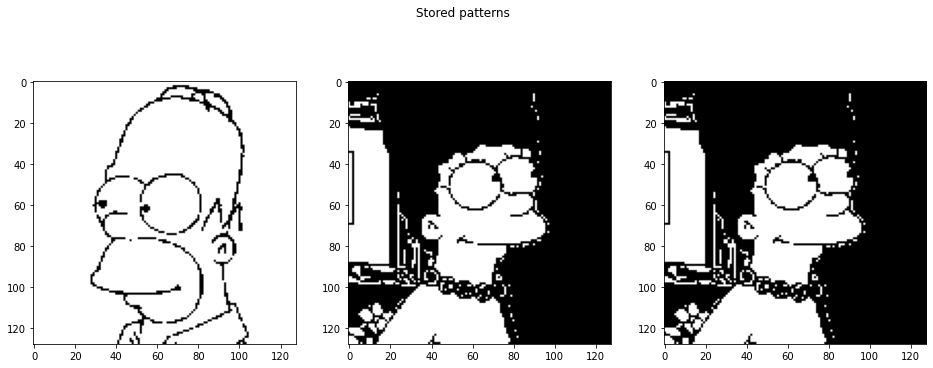

Stopped at iteration 10


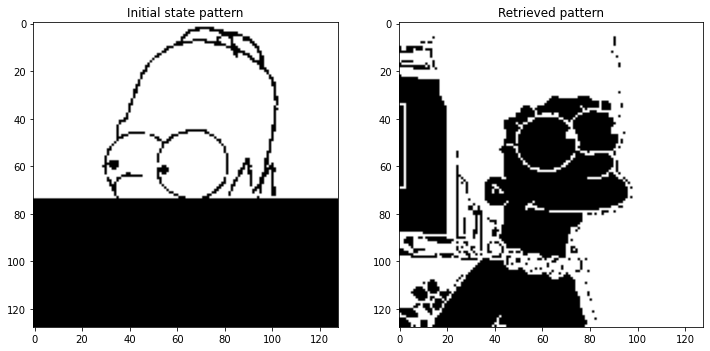

In [10]:
im_ids = ['13.png', '363.png', '363.png']
set2 = load_images(im_ids)
X = np.array([np.array(img) for img in set2]).reshape(3, width * height).T
W = X @ X.T
et = retrieve_pattern(e0.copy(), W)
plot_retrieval(e0, et)

So when we try to deal with multiple patterns the retrieval process is no longer perfect.

The new update rule proposed is as follows:
$$
\xi^{new}[l] = sgn[-E(\xi^{(l+)}) + E(\xi^{(l-)})]
$$
And considering the energy function $E$ as:
$$
E=-\sum_{i=1}^N \exp(x_i^T\xi) = \\
E= -\exp(lse(1, X^T\xi))
$$
**Note:** Notice that the new energy does not use a $W$ matrix as standard hopfield, but rather a matrix of the stored patterns $X$. The energy function operates directly over the stored matterns.

Whe end up with the complete engery function as:
$$
\xi^{new}[l] = sgn[\sum_{i=1}^N\exp(x_i^T\xi^{(l+)}) - \sum_{i=1}^N\exp(x_i^T\xi^{(l-)})]
$$
Where $\xi^{l+}[l] = 1$ and $\xi^{l-}[l] = -1$ and $\xi^{(l+)}[k] = \xi^{(l-)}[k] = \xi[k]$ for $k \ne 1$, i.e., every update, updates only component $l$ by calculating the pattern energy with all components the same ($k$) except for component $l$.


In [11]:
from scipy.special import logsumexp


def new_energy(X, state, b = 1e-3):
    """new hopfield energy function as per paper.
    Large numbers make np.exp overflow, so 
    in this implementation it is necessary to
    add a term (b) to downsize the dot product
    result, and not take the exponential in the 
    end.
    """
    # return -np.exp(np.log(np.sum(np.exp(n(X.T @ state)))))
    # return -np.exp(logsumexp(b * (X.T @ state)))
    return -logsumexp(X.T @ state, b=b)
    # return -np.exp(np.log(np.sum(X.T @ state)))
    # return -np.exp((b ** -1) * np.log(np.sum(np.exp(b * (X.T @ state)))))

Now we also need to define a new update rule as per new definition

In [12]:
import sys

def retrieve_pattern_nur(et, X, steps: int = 200, energy_fn = new_energy):
    b = 1 / (np.sqrt(X.shape[0]))
    energy_old = np.infty
    energy_new = energy_fn(et, X, b)
    iteration = 0

    while (energy_old > energy_new) and iteration < steps:
        iteration += 1
        energy_old = energy_new

        # full async update
        for l in np.random.randint(0, len(et), width * height):
                # print(f"l: {l.shape}, X[l, :]: ({W[l, :].shape},  et: ({et.shape}))")
                eplus, eminus = et.copy(), et.copy()
                eplus[l] = 1.
                eminus[l] = -1.
                et[l] = np.sign(-energy_fn(X, eplus, b) + energy_fn(X, eminus, b))
        
        energy_new = energy_fn(et, X, b)

    print(f"Stopped at iteration {iteration}")
    return et

#### Single point tests
##### #1 Single pattern, querying using the pattern itself

Stopped at iteration 1


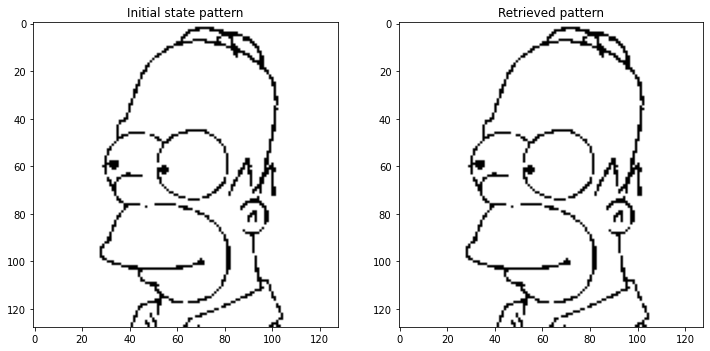

In [13]:
# X = np.array([np.array(img).flatten() for img in set1]).T
X = np.array(set1[0]).flatten()
# X = X.astype('float128')
homer = np.array(set1[0]).flatten().reshape(-1, 1)
retrieved = retrieve_pattern_nur(homer.copy(), X)
plot_retrieval(homer, retrieved)
assert (retrieved == homer).all(), "Single point test failed!! both images should be the same"

##### #2 Single pattern, querying using a masked pattern 

Stopped at iteration 9


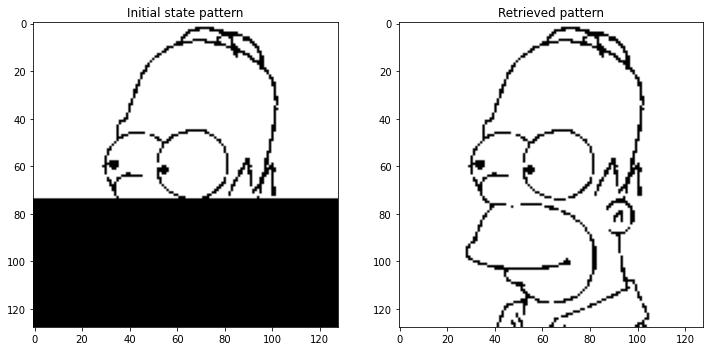

In [14]:
et = retrieve_pattern_nur(e0.copy(), X)
plot_retrieval(e0, et)
assert (et == homer).all(), "Single point test failed!! both images should be the same"

#### #3 Multiple patterns, querying using the first pattern itself

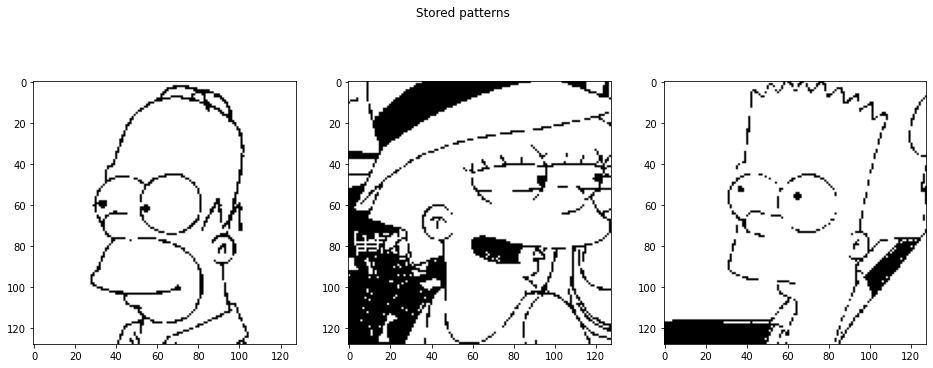

Stopped at iteration 1


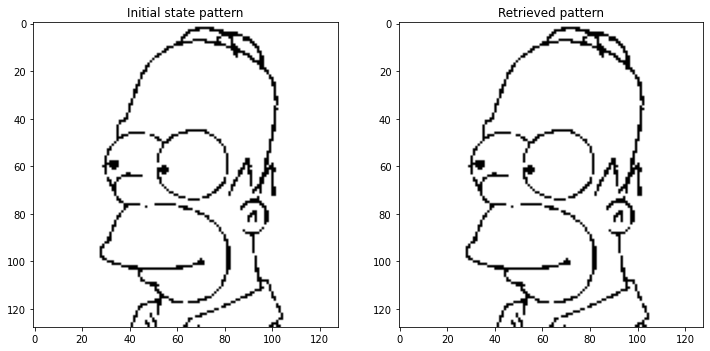

In [15]:
im_ids = ['13.png', '8.png', '28.png']
set1 = load_images(im_ids)
X = np.array([np.sign(np.array(img).flatten()) for img in set1]).T
et = retrieve_pattern_nur(homer.copy(), X)
plot_retrieval(homer, et)
assert (et == homer).all(), "Single point test failed!! both images should be the same"

#### #4 Multiple patterns, querying using a masked pattern

Stopped at iteration 10


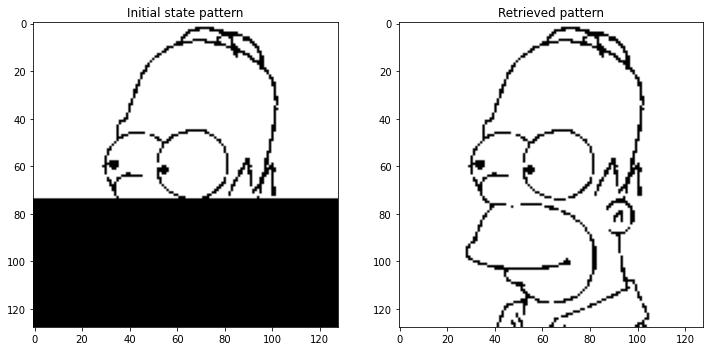

In [16]:
et = retrieve_pattern_nur(e0.copy(), X)
plot_retrieval(e0, et)
assert (et == homer).all(), "Single point test failed!! both images should be the same"

##### #5 Larger number of stored patterns, queryin using first pattern

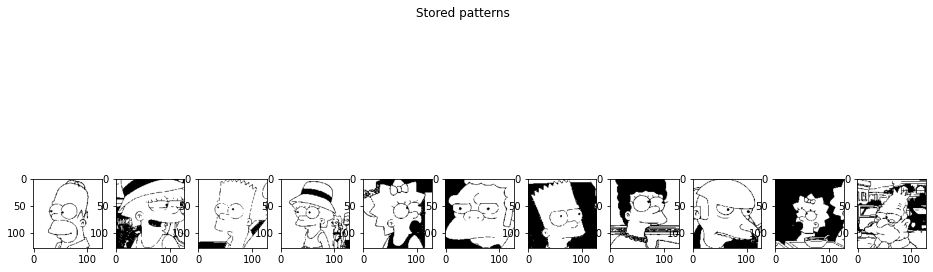

Stopped at iteration 1


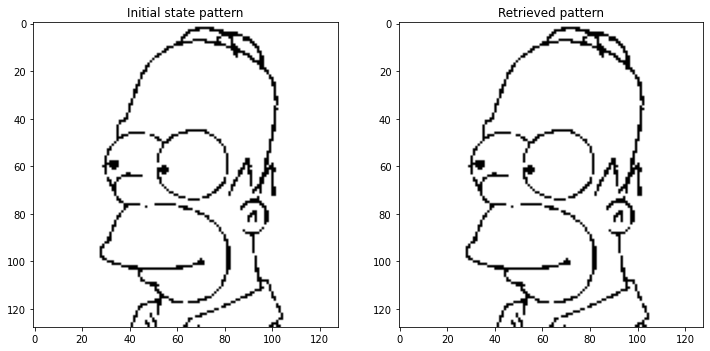

In [17]:
im_ids = ['13.png', '8.png', '28.png', '16.png', '18.png', '50.png', '67.png', '83.png', '203.png', '345.png', '953.png']
set1 = load_images(im_ids)
X = np.array([np.sign(np.array(img).flatten()) for img in set1]).T
et = retrieve_pattern_nur(homer.copy(), X)
plot_retrieval(homer, et)
assert (et == homer).all(), "Single point test failed!! both images should be the same"

##### #6 Large number of patterns, querying with masked pattern
Hypothesis: This test case fails because the masked pattern is masked using `-1` as masked value, which in the vector space of the stored patterns, it is informative, hence, the information it is carrying is matching with some of the stored patterns.

Stopped at iteration 9


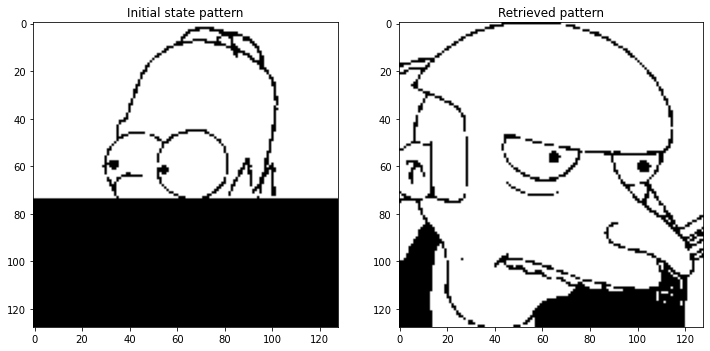

AssertionError: Single point test failed!! both images should be the same

In [18]:
et = retrieve_pattern_nur(e0.copy(), X)
plot_retrieval(e0, et)
assert (et == homer).all(), "Single point test failed!! both images should be the same"

#### #7 Large number of patterns, queryin with masked pattern v2
Continuing from test #6, this time the masked pattern uses `0` as mask value, hence the dimension is not providing any information, this would allow the async update rule to evaluate on every pixel without the others interferring with the energy calculation. Hence, in this case the perfect pattern is retrieved.

Stopped at iteration 10


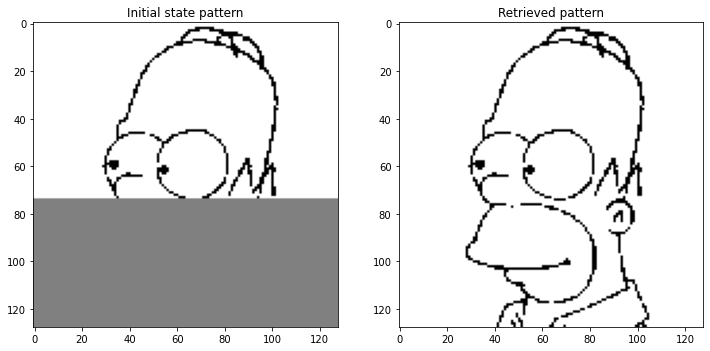

In [19]:
m_homer = homer.copy().reshape(width, height)
m_homer[width // 2 + 10: width, 0: height] = 0
emh = m_homer.flatten().reshape(-1, 1)
et = retrieve_pattern_nur(emh.copy(), X)
plot_retrieval(emh, et)
assert (et == homer).all(), "Single point test failed!"